<a href="https://colab.research.google.com/github/sanjuth/dlvs/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implement an image classification model using transfer learning techniques and check accuracy. Tune the required hyperparameters.

Data Set: https://www.kaggle.com/datasets/tongpython/cat-and-dog



In [ ]:
import numpy as np
import os
import random
import tensorflow as tf
seed_value=12321
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image

In [ ]:
def load_imgs(impath):
    imgs=[]
    label=[]
    l1=os.listdir(impath)
    for i in l1:
        c=0
        l2=os.listdir(impath+'/'+i)
        l2.remove('_DS_Store')
        for j in l2:
            
            if c<=1000:
                img=Image.open(impath+i+'/'+j)
                img=img.resize(size=(224,224))
                #img=img.convert('L')
                #img=np.array(img,dtype=np.float16)/255
                imgs.append(np.array(img)) #.flatten())
                label.append(i)
                del img
                c=c+1

        '''if(c%1000==0):
            plt.imshow(img)
            plt.show()
            c=c+1'''
    return np.array(imgs),label

In [ ]:
x_imgs,x_label=load_imgs('/kaggle/input/cat-and-dog/training_set/training_set/')
x_imgs.shape,len(x_label)

((2002, 224, 224, 3), 2002)

In [ ]:
import pandas as pd
label_cat=pd.Series(x_label,dtype='category')
#print(len(np.unique(x_label)))
# print(label_cat)
# print(label_cat.value_counts())
t=label_cat.cat.codes

In [ ]:
from sklearn.model_selection import train_test_split
train_img,test_img,train_lbl,test_lbl=train_test_split(x_imgs,t,test_size=0.2)
train_img.shape,train_lbl.shape,test_img.shape,test_lbl.shape

((1601, 224, 224, 3), (1601,), (401, 224, 224, 3), (401,))

In [ ]:
train_img=train_img.astype('float32')/255
test_img=test_img.astype('float32')/255

In [ ]:
print(train_lbl,len(train_lbl),train_lbl[:10])

491     1
386     1
140     1
117     1
1042    0
       ..
1027    0
901     1
428     1
1063    0
225     1
Length: 1601, dtype: int8 1601 491     1
386     1
140     1
117     1
1042    0
1280    0
645     1
200     1
1011    0
459     1
dtype: int8


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16()
model.summary()

2022-12-17 02:37:43.482759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 02:37:43.483729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 02:37:43.792010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 02:37:43.793123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 02:37:43.794060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

553476096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
##############################################
###TRANSFER LEARNING top layers of VGG16######
##############################################
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.optimizers import RMSprop,SGD
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
WIDTH=224
HEIGHT=224
n_channels=3
def VGG16_FC1(wdth,hght):
    model = VGG16(weights='imagenet',include_top=True,pooling='max', input_tensor=Input(shape=(wdth,hght,n_channels)))
    my_model=Model(inputs=model.input, outputs=model.layers[-3].output)
                   
    return my_model

conv_base=VGG16_FC1(WIDTH,HEIGHT)
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'fc1':
        set_trainable= True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False       
conv_base.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
input_a = Input(shape=(WIDTH, HEIGHT, 3))
from keras.callbacks import ModelCheckpoint
print(input_a)
# because we re-use the same instance `conv_base`,
# the weights of the network
# will be shared across the two branches
proc_a = conv_base(input_a)
from tensorflow.keras.layers import Dense,Flatten
fltn = Flatten()(proc_a)
dns1 = Dense(1500,activation='relu')(fltn)
dns2 = Dense(2000,activation='relu')(dns1)
dns2 = Dense(2500,activation='relu')(dns1)
dns2 = Dense(3000,activation='relu')(dns2)

dns3 = Dense(2,activation='softmax')(dns2)

model = Model(inputs=[input_a], outputs=dns3)
model.summary()
# train
rms = RMSprop()
opt = SGD(lr=0.01, momentum=0.9)
filepath="temp_update.h5"
checkpoint = ModelCheckpoint(filepath,verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['acc','mae'])

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 4096)              117479232 
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 1500)              6145500   
_________________________________________________________________
dense_2 (Dense)              (None, 2500)              3752500   
_________________________________________________________________
dense_3 (Dense)              (None, 30

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


2022-12-17 02:37:55.270264: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 963981312 exceeds 10% of free system memory.
2022-12-17 02:37:56.380229: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 963981312 exceeds 10% of free system memory.
2022-12-17 02:37:57.179541: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-12-17 02:37:59.769907: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


33/33 [==============================] - 30s 312ms/step - loss: 1.4436 - acc: 0.5153 - mae: 0.5000 - val_loss: 1.5093 - val_acc: 0.5162 - val_mae: 0.5000

Epoch 00001: val_loss improved from inf to 1.50931, saving model to temp_update.h5
Epoch 2/30
33/33 [==============================] - 9s 275ms/step - loss: 0.7449 - acc: 0.5128 - mae: 0.5000 - val_loss: 0.8603 - val_acc: 0.4838 - val_mae: 0.5000

Epoch 00002: val_loss improved from 1.50931 to 0.86033, saving model to temp_update.h5
Epoch 3/30
33/33 [==============================] - 9s 272ms/step - loss: 0.6766 - acc: 0.5522 - mae: 0.5000 - val_loss: 1.3896 - val_acc: 0.4838 - val_mae: 0.5000

Epoch 00003: val_loss did not improve from 0.86033
Epoch 4/30
33/33 [==============================] - 9s 274ms/step - loss: 0.6983 - acc: 0.5565 - mae: 0.5000 - val_loss: 1.7917 - val_acc: 0.4838 - val_mae: 0.5000

Epoch 00004: val_loss did not improve from 0.86033
Epoch 5/30
33/33 [==============================] - 9s 279ms/step - loss: 0.71

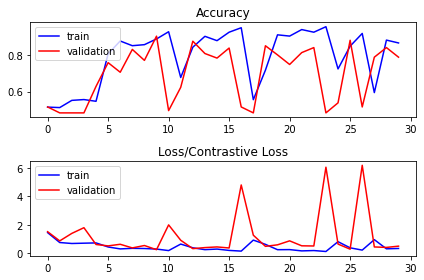

In [ ]:
nb_epochs =30
history = model.fit(train_img, train_lbl,
          validation_data=(test_img, test_lbl),
          batch_size=50,callbacks=[checkpoint],
          epochs=nb_epochs)
model.save_weights('esy_cat_lss_imelon.hdf5')

import matplotlib.pyplot as plt

plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="blue", label="train")
plt.plot(history.history["val_acc"], color="red", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss/Contrastive Loss")
plt.plot(history.history["loss"], color="blue", label="train")
plt.plot(history.history["val_loss"], color="red", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [ ]:
model.evaluate(test_img,test_lbl)

13/13 [==============================] - 12s 446ms/step - loss: 0.4885 - acc: 0.7880 - mae: 0.5000


[0.48852673172950745, 0.7880299091339111, 0.5]